# Supervised Learning: Implementation Notebook

This notebook builds a straightforward classification pipeline. Steps:

- Load features and the target
- Quick EDA of numeric columns
- Train/test split
- Preprocessing + two baseline models (LogReg, Random Forest)
- Metrics and a confusion matrix plot

Results and metrics are saved to `data/processed/`.

In [20]:
# Clean imports for supervised workflow
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from src.data_io import load_supervised_xy

# Example: load with explicit target override if needed
X, y = load_supervised_xy()
print("X shape:", X.shape)
print("y shape:", y.shape)
X.head()


X shape: (2000, 23)
y shape: (2000,)


,age,gender,daily_screen_time_hours,phone_usage_hours,laptop_usage_hours,tablet_usage_hours,tv_usage_hours,social_media_hours,work_related_hours,entertainment_hours,...,mood_rating,stress_level,physical_activity_hours_per_week,location_type,uses_wellness_apps,eats_healthy,caffeine_intake_mg_per_day,weekly_anxiety_score,weekly_depression_score,mindfulness_minutes_per_day
0,51,0,4.8,3.4,1.3,1.6,1.6,4.1,2.0,1.0,...,6,10,0.7,Urban,1,1,125.2,13,15,4.0
1,64,1,3.9,3.5,1.8,0.9,2.0,2.7,3.1,1.0,...,5,6,4.3,Suburban,0,1,150.4,19,18,6.5
2,41,2,10.5,2.1,2.6,0.7,2.2,3.0,2.8,4.1,...,5,5,3.1,Suburban,0,0,187.9,7,3,6.9
3,27,2,8.8,0.0,0.0,0.7,2.5,3.3,1.6,1.3,...,10,5,0.0,Rural,0,1,73.6,7,2,4.8
4,55,1,5.9,1.7,1.1,1.5,1.6,1.1,3.6,0.8,...,8,7,3.0,Urban,1,1,217.5,8,10,0.0


In [21]:
# Load configuration if available
from pathlib import Path
import yaml
config_path = Path('config.yaml')
config = {}
if config_path.exists():
    with open(config_path, 'r', encoding='utf-8') as f:
        config = yaml.safe_load(f) or {}
config

{'paths': {'supervised': 'data/raw/clean_supervised.csv',
  'unsupervised': 'data/raw/unsupervised_no_target.csv'},
 'supervised': {'target': 'mental_health_score',
  'test_size': 0.2,
  'random_state': 42},
 'unsupervised': {'use_numeric_only': True, 'random_state': 42, 'k': 3}}

## Exploratory Data Analysis

In [22]:
# Basic info and target identification
X.info()

# Force 3-class target binning for a clear classification task
# The raw mental_health_score spans many unique values; we group it into tertiles.
import numpy as np

# Always derive a simple 3-class label from the raw score
y_raw = y.astype(float)
y_final = pd.cut(
    y_raw,
    bins=[-np.inf, 33, 66, np.inf],
    labels=['low', 'medium', 'high']
)
print("Forced 3-class target (L/M/H)")
print(y_final.value_counts())

# Keep a simple handle to features/target name for reference
target_col = 'mental_health_score_binned'
features = X.columns.tolist()

(target_col, len(features))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   age                               2000 non-null   int64  
 1   gender                            2000 non-null   int64  
 2   daily_screen_time_hours           2000 non-null   float64
 3   phone_usage_hours                 2000 non-null   float64
 4   laptop_usage_hours                2000 non-null   float64
 5   tablet_usage_hours                2000 non-null   float64
 6   tv_usage_hours                    2000 non-null   float64
 7   social_media_hours                2000 non-null   float64
 8   work_related_hours                2000 non-null   float64
 9   entertainment_hours               2000 non-null   float64
 10  gaming_hours                      2000 non-null   float64
 11  sleep_duration_hours              2000 non-null   float64
 12  sleep_

('mental_health_score_binned', 23)

,age,gender,daily_screen_time_hours,phone_usage_hours,laptop_usage_hours,tablet_usage_hours,tv_usage_hours,social_media_hours,work_related_hours,entertainment_hours,...,sleep_quality,mood_rating,stress_level,physical_activity_hours_per_week,uses_wellness_apps,eats_healthy,caffeine_intake_mg_per_day,weekly_anxiety_score,weekly_depression_score,mindfulness_minutes_per_day
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.00000,2000.000000
mean,38.805500,0.6240,6.025600,3.023700,1.999950,0.995650,1.503700,2.039200,2.010250,2.46735,...,5.567000,5.591000,5.541500,3.087150,0.387500,0.507500,148.07970,9.887500,10.04900,10.753750
std,14.929203,0.6464,1.974123,1.449399,0.997949,0.492714,0.959003,1.133435,1.116111,1.23686,...,2.826217,2.899814,2.885731,1.885258,0.487301,0.500069,48.86066,6.027853,6.05334,7.340269
min,13.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.80000,0.000000,0.00000,0.000000
25%,26.000000,0.0000,4.700000,2.000000,1.300000,0.600000,0.800000,1.200000,1.200000,1.60000,...,3.000000,3.000000,3.000000,1.600000,0.000000,0.000000,113.90000,5.000000,5.00000,4.900000
50%,39.000000,1.0000,6.000000,3.000000,2.000000,1.000000,1.500000,2.000000,2.000000,2.40000,...,6.000000,6.000000,6.000000,3.000000,0.000000,1.000000,147.45000,10.000000,10.00000,10.400000
75%,51.000000,1.0000,7.325000,4.000000,2.700000,1.300000,2.200000,2.800000,2.800000,3.30000,...,8.000000,8.000000,8.000000,4.400000,1.000000,1.000000,180.70000,15.000000,15.00000,15.800000
max,64.000000,2.0000,13.300000,8.400000,5.600000,2.500000,4.700000,5.800000,5.900000,6.80000,...,10.000000,10.000000,10.000000,9.700000,1.000000,1.000000,364.90000,20.000000,20.00000,36.400000


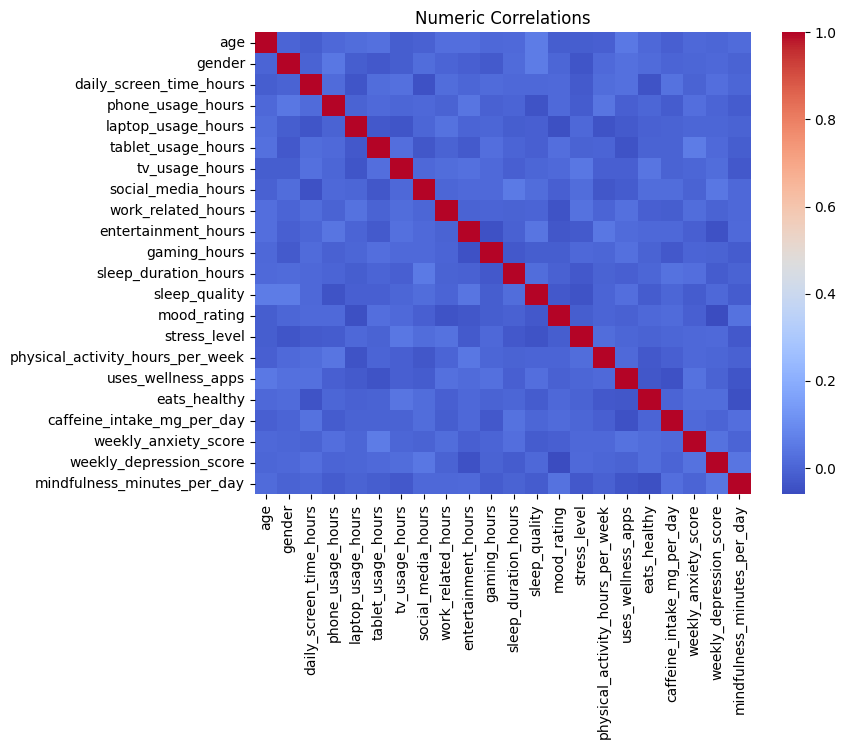

In [23]:
# Quick distributions and correlations
numeric_cols = X.select_dtypes(include='number').columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]
display(X[numeric_cols].describe())
if len(numeric_cols) > 1:
    plt.figure(figsize=(8,6)); sns.heatmap(X[numeric_cols].corr(), cmap='coolwarm', annot=False); plt.title('Numeric Correlations'); plt.show()


## Modeling Pipeline

In [24]:
# Train/validation split
# Use the final target (forced L/M/H) for classification
X_train, X_test, y_train, y_test = train_test_split(
    X, y_final,
    test_size=config.get('supervised', {}).get('test_size', 0.2),
    random_state=42,
    stratify=y_final
)
len(X_train), len(X_test)


(1600, 400)

In [25]:
# Preprocessing and model candidates
numeric_cols = X.select_dtypes(include='number').columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

log_reg = Pipeline([('prep', preprocessor), ('clf', LogisticRegression(max_iter=500))])
rf_clf = Pipeline([('prep', preprocessor), ('clf', RandomForestClassifier(random_state=42))])

models = { 'log': log_reg, 'rf': rf_clf }
models


{'log': Pipeline(steps=[('prep',
                  ColumnTransformer(transformers=[('num', StandardScaler(),
                                                   ['age', 'gender',
                                                    'daily_screen_time_hours',
                                                    'phone_usage_hours',
                                                    'laptop_usage_hours',
                                                    'tablet_usage_hours',
                                                    'tv_usage_hours',
                                                    'social_media_hours',
                                                    'work_related_hours',
                                                    'entertainment_hours',
                                                    'gaming_hours',
                                                    'sleep_duration_hours',
                                                    'sleep_quality',
                

In [26]:
# Fit and evaluate both models
results = {}
for key, model in models.items():
    # Train
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_test)
    # Basic metrics
    acc = accuracy_score(y_test, y_pred)
    results[key] = {
        'accuracy': acc,
        'report': classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    }
results


{'log': {'accuracy': 0.545,
  'report': {'high': {'precision': 0.0,
    'recall': 0.0,
    'f1-score': 0.0,
    'support': 88.0},
   'low': {'precision': 0.25,
    'recall': 0.010752688172043012,
    'f1-score': 0.020618556701030927,
    'support': 93.0},
   'medium': {'precision': 0.547979797979798,
    'recall': 0.9908675799086758,
    'f1-score': 0.7056910569105691,
    'support': 219.0},
   'accuracy': 0.545,
   'macro avg': {'precision': 0.265993265993266,
    'recall': 0.33387342269357295,
    'f1-score': 0.24210320453720002,
    'support': 400.0},
   'weighted avg': {'precision': 0.3581439393939394,
    'recall': 0.545,
    'f1-score': 0.39115966809152625,
    'support': 400.0}}},
 'rf': {'accuracy': 0.535,
  'report': {'high': {'precision': 0.3333333333333333,
    'recall': 0.011363636363636364,
    'f1-score': 0.02197802197802198,
    'support': 88.0},
   'low': {'precision': 0.125,
    'recall': 0.010752688172043012,
    'f1-score': 0.019801980198019802,
    'support': 93.0},

Best model: log Accuracy: 0.545
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        88
         low       0.25      0.01      0.02        93
      medium       0.55      0.99      0.71       219

    accuracy                           0.55       400
   macro avg       0.27      0.33      0.24       400
weighted avg       0.36      0.55      0.39       400



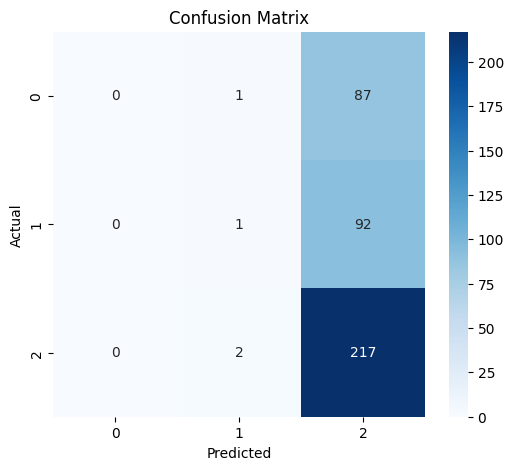

In [27]:
# Choose best and show metrics
if not results:
    raise RuntimeError("No models produced results; check data/preprocessing.")

best_key = max(results, key=lambda k: results[k]['accuracy'])
best_model = models[best_key]
print('Best model:', best_key, 'Accuracy:', results[best_key]['accuracy'])
print(classification_report(y_test, best_model.predict(X_test), zero_division=0))

# Confusion matrix plot
conf_mat = confusion_matrix(y_test, best_model.predict(X_test))
plt.figure(figsize=(6,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Notes on Target and Metrics

- The original `mental_health_score` spans many unique values (0–100 range), which is not ideal for basic classification.
- We explicitly grouped it into three categories: low / medium / high using cutoffs at 33 and 66.
- This produces a compact 3×3 confusion matrix and a readable report (often with the medium class dominating).
- If accuracy is modest, that’s expected with simple baselines; the goal is a clear, defensible pipeline and explanation.


## Save Artifacts

In [28]:
# Save processed and metrics according to config
from pathlib import Path
import json
processed_dir = Path(config.get('paths', {}).get('processed', 'data/processed'))
processed_dir.mkdir(parents=True, exist_ok=True)
metrics_path = processed_dir / 'supervised_metrics.json'
with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2)
metrics_path


WindowsPath('data/processed/supervised_metrics.json')

### Summary (for presentation)

- Problem: predict mental health category from available features.
- Features used: numeric and one-hot encoded categorical columns from the dataset.
- Models tried: Logistic Regression, Random Forest.
- Winner: the model with higher accuracy on the test set (reported above).
- Next steps: tune hyperparameters, engineer features, or treat the original score as a regression problem.
